## Перенос знаний на наборе данных MNIST

Решение по переносу знаний (Transfer Learning) для задачи распознавания рукописных цифр на наборе данных MNIST.

Будем использовать предобученную модель ResNet50.

Импорт библиотек.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

Трансформация изображений для использования модели ResNet50.
1. Изменяем размер
2. Переводим в grayscale
3. Приводим в формат тензора
4. Нормализуем значения пикселей

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Загружаем датасет MNIST.

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.4kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.35MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Проверка размера данных.

In [4]:
print(next(iter(train_loader))[0].shape)

torch.Size([32, 3, 224, 224])


 Загружаем предобученную ResNet50.

In [5]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


Замораживаем слои предобученной модели


In [6]:
for param in model.parameters():
    param.requires_grad = False

Заменяем последний слой классификации (fc).
</br>
</br>
num_ftrs - получаем число входных фичей последнего полносвязного слоя.
</br>
Переопределяем model.fc - линейный слой с выходным количеством фич 512, функция активации ReLU, Dropout для предотвращения переобучения, линейный слой с выходным количеством фичей 10, что соответствует количеству классов в MNIST.

In [7]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 10)
)

Устройство (CPU/GPU).
Выбираем GPU, если возможно.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model.to(device)

Device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Определяем оптимизатор и функцию потерь.
</br>
CrossEntropyLoss - стандартная функция потерь для многоклассовой классификации. Она сочетает в себе две операции: Softmax и NLLLoss.
</br>
Adam — это один из наиболее популярных оптимизаторов для глубоких нейронных сетей. Преимущества Adam: Адаптивная корректировка скорости обучения и использование моментов для более эффективной оптимизации.
</br>
model.fc.parameters() - обновляем параметры только последнего слоя модели.
</br>
lr=0.001 - скорость обучения для оптимизатора, регулирует, насколько сильно будут изменяться веса модели на каждом шаге оптимизации

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Функция обучения:


Инициализация: Устанавливает модель в режим обучения (model.train()).


Цикл по эпохам: Для каждой эпохи выполняется:
* Прогон через весь датасет (батчи данных).

* Обработку входных данных (перемещение их на устройство device).

* Обновление параметров модели через обратное распространение ошибки и шаг оптимизатора.

* Подсчёт общей потери и точности модели на текущем батче.


Вывод: По окончании каждой эпохи выводит среднюю потерю и точность на всей обучающей выборке.

In [10]:
def train(model, loader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        total_loss = 0
        correct = 0
        total_samples = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            #зануляем градиенты, вычисленные на предыдущем шаге
            optimizer.zero_grad()

            #прямой проход
            outputs = model(images)

            #вычисление потерь
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            #подсчет правильных классификаций
            _, predicted = torch.max(outputs, 1)  #получаем индексы максимальных значений
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        #среднее значение потерь и точности за эпоху
        avg_loss = total_loss / len(loader)
        accuracy = (correct / total_samples) * 100

        print(f" Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Обучаем первые 5 эпох.

In [11]:
train(model, train_loader, optimizer, criterion, device, epochs=5)

Training Epochs:  20%|██        | 1/5 [01:39<06:38, 99.57s/it]

 Epoch [1/5], Loss: 0.4720, Accuracy: 84.78%


Training Epochs:  40%|████      | 2/5 [03:16<04:53, 97.87s/it]

 Epoch [2/5], Loss: 0.3129, Accuracy: 89.66%


Training Epochs:  60%|██████    | 3/5 [04:53<03:15, 97.62s/it]

 Epoch [3/5], Loss: 0.2714, Accuracy: 91.19%


Training Epochs:  80%|████████  | 4/5 [06:30<01:37, 97.31s/it]

 Epoch [4/5], Loss: 0.2519, Accuracy: 91.70%


Training Epochs: 100%|██████████| 5/5 [08:07<00:00, 97.48s/it]

 Epoch [5/5], Loss: 0.2425, Accuracy: 92.20%


Размораживаем последний блок ResNet.

In [12]:
for param in model.layer4.parameters():
    param.requires_grad = True

Обновляем оптимизатор для fine-tuning.

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Обучаем еще 5 эпох с fine-tuning.

In [14]:
train(model, train_loader, optimizer, criterion, device, epochs=5)

Training Epochs:  20%|██        | 1/5 [01:44<06:56, 104.07s/it]

 Epoch [1/5], Loss: 0.0881, Accuracy: 97.39%


Training Epochs:  40%|████      | 2/5 [03:27<05:11, 103.95s/it]

 Epoch [2/5], Loss: 0.0368, Accuracy: 98.84%


Training Epochs:  60%|██████    | 3/5 [05:12<03:28, 104.10s/it]

 Epoch [3/5], Loss: 0.0282, Accuracy: 99.17%


Training Epochs:  80%|████████  | 4/5 [06:56<01:44, 104.19s/it]

 Epoch [4/5], Loss: 0.0216, Accuracy: 99.34%


Training Epochs: 100%|██████████| 5/5 [08:40<00:00, 104.09s/it]

 Epoch [5/5], Loss: 0.0169, Accuracy: 99.49%


Функция тестирования:
 выполняет оценку модели на тестовом наборе данных. Рассчитывает метрики и матрицу ошибок для оценки качества предсказаний модели.
 </br>
 Инициализация: Устанавливает модель в режим оценки (model.eval()). Инициализирует списки для хранения предсказаний и истинных классов. Отключает вычисление градиентов.
 </br>
 Перебирает все батчи из тестового загрузчика. Получает предсказания модели.
 </br>
 Считает метрики по полученным спискам и выводит матрицу ошибок.

In [15]:
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            #перемещаем данные на устройство
            images, labels = images.to(device), labels.to(device)
            #делаем предсказание
            outputs = model(images)

            #выбираем класс с наибольшей вероятностью
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #считаем метрики accuracy, precision, recall, f1
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    #матрица ошибок
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Оценка модели:

Accuracy: 0.9945
Precision: 0.9945
Recall: 0.9945
F1-Score: 0.9945


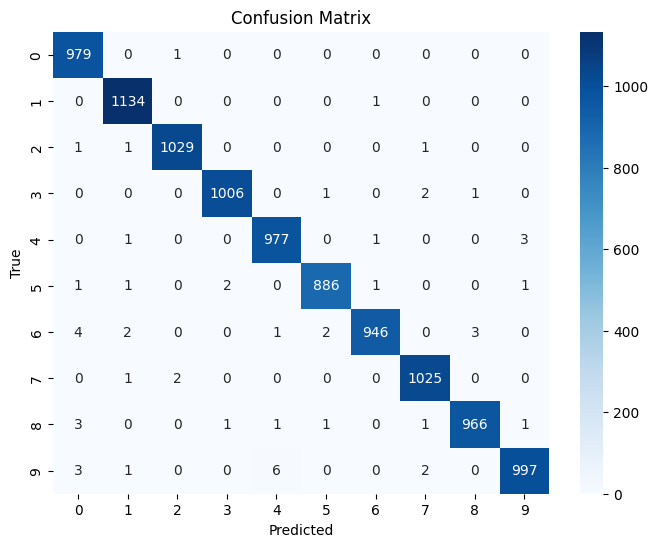

In [16]:
evaluate(model, test_loader, device)

Можем сделать вывод, что полученная модель довольно точно предсказывает классы цифр для набора MNIST.